In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

from collections import Counter

In [131]:
X_cols = ['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ', 'HOUR_X', 'HOUR_Y',
       'CRASHSEVER_Fatal', 'CRASHSEVER_Injury', 'DRIVER1SEX_M', 'DRIVER1SEX_U',
       'EMRGVEH_Yes', 'ALCOHOL_INVOLVED_Yes', 'MOTORCYCLE_Yes',
       'D1COND_Appeared Normal', 'D1COND_Fatigue / Sick']
y_cols = 'HITANDRUN_Yes'

In [132]:
crash_data = pd.read_csv('Data/Analysis2/Crash_data_prepared.csv')
X = crash_data.loc[:, X_cols]
y = crash_data.loc[:, y_cols]

In [133]:
# Class weights
n_samples = len(X)
n_classes = 2
class_weights = n_samples / (n_classes * np.bincount(y))
print('class weight for 0 is:', class_weights[0])
print('class weight for 1 is:', class_weights[1])

class weight for 0 is: 0.636708661967
class weight for 1 is: 2.32870636288


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [135]:
print(sorted(Counter(y_test).items()))

[(0, 18944), (1, 5139)]


In [136]:
# Fit the SVM model
clf = SVC(kernel='linear')
clf.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

* Here are [great classification metric explanations](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for unbalanced classification problems like this one, it looks like recall is our best bet

In [137]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.99      0.92     18944
          1       0.89      0.42      0.57      5139

avg / total       0.87      0.86      0.84     24083



In [138]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)

True negatives: 18679
True positives: 2136
False negatives: 3003
False Positives: 265


In [139]:
confusion_matrix(y_test, y_pred)

array([[18679,   265],
       [ 3003,  2136]])

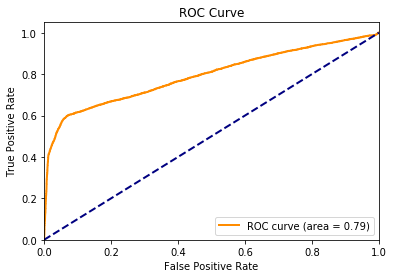

In [140]:
y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---

---

## Statistical Re-sampling
Since the recall was still very low after training our SVM, we will use a statistical re-sampling technique designed for dealing with imbalanced classes, like ours. We'll be using some tools from the [imbalanced-learn package](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)

In [141]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import AllKNN

In [145]:
print(sorted(Counter(y).items()))

[(0, 57308), (1, 15669)]


In [154]:
pipeline = make_pipeline(AllKNN(random_state=1),
                            SVC(kernel = 'linear'))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred = pipeline.predict(X_test)

In [158]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.90      0.90     14348
          1       0.63      0.65      0.64      3897

avg / total       0.85      0.84      0.85     18245



In [159]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)

True negatives: 12889
True positives: 2523
False negatives: 1374
False Positives: 1459


---

In [155]:
from sklearn import tree
import graphviz

In [156]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=4)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=4, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

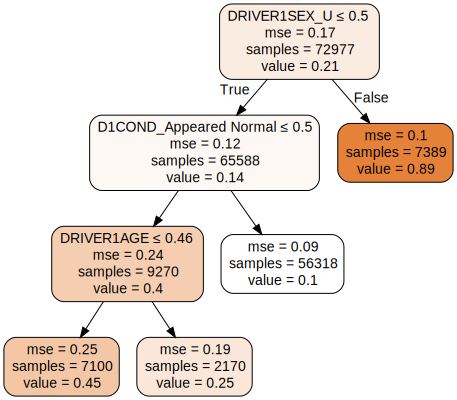

In [157]:
dot_data = tree.export_graphviz(regr, out_file=None, 
                         feature_names=X.columns, 
                         filled=True, rounded=True,  
                         special_characters=True,
                               precision=2)
tree_viz = graphviz.Source(dot_data)
tree_viz

---